<a href="https://colab.research.google.com/github/SangeethaSusan/Exploratory-Data-Analysis-of-YouTube-Trends-Using-PySpark/blob/main/YouTubeData_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
data_path = "/content/drive/MyDrive/YouTube Video Analysis/*.csv"

In [29]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("YouTube Video Analysis").getOrCreate()

In [30]:
# Loading the data
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [31]:
# Display data
df.show(5)

+-----------+-------------+--------------------+-------------+-----------+--------------------+--------------------+------+-----+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+-------+
|   video_id|trending_date|               title|channel_title|category_id|        publish_time|                tags| views|likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|video_error_or_removed|         description|Country|
+-----------+-------------+--------------------+-------------+-----------+--------------------+--------------------+------+-----+--------+-------------+--------------------+-----------------+----------------+----------------------+--------------------+-------+
|gDuslQ9avLc|     17.14.11|Захар и Полина уч...|    Т—Ж БОГАЧ|         22|2017-11-13T09:09:...|"захар и полина|"...| 62408|  334|     190|           50|https://i.ytimg.c...|            FALSE|           FALSE|         

In [32]:
# number of rows
df.count()

416724

In [33]:
# Drop columns thumbnail_link, comment_diabled, ratings_diabled,video_error_or_removed, description
df = df.drop('tags','thumbnail_link','comments_disabled','ratings_disabled','video_error_or_removed','description')

In [34]:
df.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- views: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- dislikes: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- Country: string (nullable = true)



In [35]:
# To convert all columns into their correct type
from pyspark.sql.functions import col, to_date, to_timestamp, expr

spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df = (df.withColumn("trending_date",to_date("trending_date",'yy.dd.MM'))
      .withColumn("category_id", col("category_id").cast("int"))
      .withColumn("publish_time", to_timestamp("publish_time","yyyy-MM-dd'T'HH:mm:ss.SSS'Z'"))
      .withColumn("views", col("views").cast("long"))
      .withColumn("likes", col("likes").cast("long"))
      .withColumn("dislikes", col("dislikes").cast("long"))
      .withColumn("comment_count", col("comment_count").cast("long"))
)

## To check the Missing values

In [36]:
from pyspark.sql import functions as F

null_counts = df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c + "_nulls")
    for c in df.columns
])
null_counts.show()


+--------------+-------------------+-----------+-------------------+-----------------+------------------+-----------+-----------+--------------+-------------------+-------------+
|video_id_nulls|trending_date_nulls|title_nulls|channel_title_nulls|category_id_nulls|publish_time_nulls|views_nulls|likes_nulls|dislikes_nulls|comment_count_nulls|Country_nulls|
+--------------+-------------------+-----------+-------------------+-----------------+------------------+-----------+-----------+--------------+-------------------+-------------+
|             0|              40782|      36713|              37450|            40780|             40782|      40783|      40784|         40784|              40784|        45751|
+--------------+-------------------+-----------+-------------------+-----------------+------------------+-----------+-----------+--------------+-------------------+-------------+



## Filling and dropping the missing values

In [37]:
num_cols = ["views", "likes", "dislikes", "comment_count"]

# Compute medians in one go
medians = {col: df.approxQuantile(col, [0.5], 0.001)[0] for col in num_cols}

# Fill nulls with medians
df = df.na.fill(medians)


In [38]:
df = df.fillna({
    'title':'No title',
    'channel_title':'No channel title',
    'category_id':0,
    'Country':'Unknown'
})

In [39]:
# removing null rows from publishing_time, trending_date
df = df.na.drop(subset=['publish_time','trending_date'])

## To check the Missing values

In [40]:
from pyspark.sql import functions as F

null_counts = df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c + "_nulls")
    for c in df.columns
])
null_counts.show()


+--------------+-------------------+-----------+-------------------+-----------------+------------------+-----------+-----------+--------------+-------------------+-------------+
|video_id_nulls|trending_date_nulls|title_nulls|channel_title_nulls|category_id_nulls|publish_time_nulls|views_nulls|likes_nulls|dislikes_nulls|comment_count_nulls|Country_nulls|
+--------------+-------------------+-----------+-------------------+-----------------+------------------+-----------+-----------+--------------+-------------------+-------------+
|             0|                  0|          0|                  0|                0|                 0|          0|          0|             0|                  0|            0|
+--------------+-------------------+-----------+-------------------+-----------------+------------------+-----------+-----------+--------------+-------------------+-------------+



In [41]:
# Dropping duplicates
df= df.dropDuplicates(["video_id","trending_date","Country"])

In [42]:
df.count()

359391

In [43]:
# Creating a new cleaned HiveQL Table YouTubeData
df.createOrReplaceTempView('YouTubeData')

In [ ]:
# Printing first 5 rows
spark.sql('SELECT * FROM YouTubeData LIMIT 5').show()

+--------+-------------+------------------------------+-----------------------+-----------+-------------------+--------------------+-------+-----+--------+-------------+-------+
|video_id|trending_date|                         title|          channel_title|category_id|       publish_time|                tags|  views|likes|dislikes|comment_count|Country|
+--------+-------------+------------------------------+-----------------------+-----------+-------------------+--------------------+-------+-----+--------+-------------+-------+
|  #NAME?|   2017-11-14|          Son mec lui disai...|              PEOPLE TV|         22|2017-11-13 17:00:33|              [none]|  11132|   50|      10|           16|     FR|
|  #NAME?|   2017-11-14|          CHRISTMAS HAS GON...|             MoreZoella|         22|2017-11-10 19:19:43|"zoe sugg|""zoell...|1164201|57309|     749|          624|     GB|
|  #NAME?|   2017-11-14|          స‌మంత కంట‌త‌డి | ...|          Friday Poster|         24|2017-11-13 08:59:27

# General Overview

In [ ]:
# 1. How many unique videos are there in the dataset?
spark.sql('SELECT COUNT(DISTINCT video_id) AS Number_of_unique_videos FROM YouTubeData').show()

+-----------------------+
|Number_of_unique_videos|
+-----------------------+
|                 183243|
+-----------------------+



In [ ]:
# 2. Which country has the most trending videos?
spark.sql('''SELECT Country ,COUNT(video_id) AS Number_of_trending_videos
FROM YouTubeData
GROUP BY Country
ORDER BY Number_of_trending_videos DESC
LIMIT 1''').show()

+-------+-------------------------+
|Country|Number_of_trending_videos|
+-------+-------------------------+
|     CA|                    39996|
+-------+-------------------------+



In [ ]:
# 3. Which video stayed trending for the longest time?
spark.sql('''SELECT title, COUNT(DISTINCT trending_date) AS Trending_days
FROM YouTubeData
GROUP BY title
ORDER BY Trending_days DESC
LIMIT 10''').show()

+--------------------+-------------+
|               title|Trending_days|
+--------------------+-------------+
|     Maroon 5 - Wait|           48|
|Nicki Minaj - Chu...|           39|
|Jurassic World: F...|           38|
|     To Our Daughter|           38|
|Justin Timberlake...|           38|
|VENOM - Official ...|           37|
|Janelle Monáe – M...|           37|
| Karol G - Pineapple|           37|
|Fergie Performs T...|           37|
|Incredibles 2 - O...|           37|
+--------------------+-------------+



In [ ]:
# 4. How many categories (category_id) are represented in the dataset?
spark.sql('''
SELECT COUNT(DISTINCT category_id) AS Number_of_categories
FROM YouTubeData
''').show()

+--------------------+
|Number_of_categories|
+--------------------+
|                  18|
+--------------------+



In [ ]:
# 5. What are the top 10 most-viewed videos?
spark.sql('''
SELECT title,max(views) as number_of_views
FROM YouTubeData
GROUP BY title
ORDER BY number_of_views DESC
LIMIT 10
''').show()

+--------------------+---------------+
|               title|number_of_views|
+--------------------+---------------+
|Nicky Jam x J. Ba...|      424538912|
|Te Bote Remix - C...|      337621571|
|Bad Bunny - Amorf...|      328860380|
|Ozuna x Romeo San...|      288811992|
|Childish Gambino ...|      259721696|
|  Drake - God’s Plan|      258164991|
|Ariana Grande - N...|      208876887|
|Becky G, Natti Na...|      200862743|
|YouTube Rewind: T...|      169884583|
|Dura - Daddy Yank...|      167456025|
+--------------------+---------------+



# Channel & Category Analysis

In [ ]:
# 6. Which channels have the highest number of trending videos?
spark.sql('''
SELECT channel_title , COUNT(DISTINCT video_id) as total_videos
FROM YouTubeData
GROUP BY channel_title
ORDER BY total_videos DESC
LIMIT 10
''').show()

+--------------------+------------+
|       channel_title|total_videos|
+--------------------+------------+
|           SET India|         251|
|              SAB TV|         246|
|           VikatanTV|         239|
|      Анатолий Шарий|         235|
|The Late Show wit...|         226|
|    Elhiwar Ettounsi|         208|
|                 WWE|         203|
|           Россия 24|         193|
|                ESPN|         185|
|                 CNN|         177|
+--------------------+------------+



In [ ]:
# 7. Which categories (category_id) tend to trend the most across countries?
spark.sql('''
SELECT category_id, Country, COUNT(DISTINCT video_id) as total_videos
FROM YouTubeData
GROUP BY category_id, Country
ORDER BY total_videos DESC
LIMIT 10
''').show()

+-----------+-------+------------+
|category_id|Country|total_videos|
+-----------+-------+------------+
|         24|     MX|       11137|
|         24|     DE|       10329|
|         22|     RU|        8842|
|         24|     CA|        7991|
|         24|     IN|        7550|
|         24|     FR|        7390|
|         22|     MX|        6945|
|         24|     RU|        4617|
|         25|     RU|        4529|
|         22|     FR|        4490|
+-----------+-------+------------+



In [ ]:
# 8. Which category has the highest average views?
spark.sql('''
SELECT category_id, AVG(views) as avg_views
FROM YouTubeData
GROUP BY category_id
ORDER BY avg_views DESC
LIMIT 5
''').show()

+-----------+-----------------+
|category_id|        avg_views|
+-----------+-----------------+
|         10|6108042.571974584|
|         30|        1774642.9|
|          1|  1325991.2667999|
|         28|1121661.288927988|
|         24|956282.1909229086|
+-----------+-----------------+



In [ ]:
# 9.  Which channels get the highest average likes-dislikes ratio?
spark.sql('''
SELECT channel_title, AVG(likes/dislikes) as avg_likes_dislikes_ratio
FROM YouTubeData
GROUP BY channel_title
ORDER BY avg_likes_dislikes_ratio DESC
LIMIT 5
''').show()

+--------------------+------------------------+
|       channel_title|avg_likes_dislikes_ratio|
+--------------------+------------------------+
|    Audience Network|                 11688.0|
|     tokkibeaglesubs|                  2686.0|
|BANG BANGTAN - Fa...|                  2028.0|
|NEWPLAN ENTERTAIN...|      1987.6000000000001|
|          Goeggi 187|                  1804.0|
+--------------------+------------------------+



# Temporal Analysis

In [ ]:
# 10. On which days of the week are videos most likely to trend?
spark.sql('''
SELECT DAYOFWEEK(trending_date) as day_of_week, COUNT(DISTINCT video_id) as total_videos
FROM YouTubeData
GROUP BY day_of_week
ORDER BY total_videos DESC
LIMIT 7
''').show()

+-----------+------------+
|day_of_week|total_videos|
+-----------+------------+
|          3|       43397|
|          7|       42945|
|          2|       41762|
|          1|       41517|
|          6|       41400|
|          4|       40950|
|          5|       40812|
+-----------+------------+



In [ ]:
# 12. What is the relationship between publish_time and the date it trended (trending_date)? (lag time analysis)
spark.sql('''
SELECT title,publish_time, trending_date, DATEDIFF(trending_date, publish_time) as lag_time
FROM YouTubeData
ORDER BY lag_time DESC
LIMIT 5
''').show()

+--------------------+-------------------+-------------+--------+
|               title|       publish_time|trending_date|lag_time|
+--------------------+-------------------+-------------+--------+
|Budweiser - Origi...|2006-07-23 08:24:11|   2018-02-05|    4215|
|Jeffrey Lewis The...|2007-03-05 16:23:55|   2018-02-05|    3990|
|Jeffrey Lewis The...|2007-03-05 16:23:55|   2018-02-04|    3989|
|Jeffrey Lewis The...|2007-03-05 16:23:55|   2018-02-03|    3988|
|Jeffrey Lewis The...|2007-03-05 16:23:55|   2018-02-02|    3987|
+--------------------+-------------------+-------------+--------+



In [ ]:
# 13. Do videos published at certain hours of the day get more views/likes?
spark.sql('''
SELECT HOUR(publish_time) as hour_of_day, AVG(views) as avg_views, AVG(likes) as avg_likes
FROM YouTubeData
GROUP BY hour_of_day
ORDER BY avg_views DESC
LIMIT 10
''').show()

+-----------+------------------+------------------+
|hour_of_day|         avg_views|         avg_likes|
+-----------+------------------+------------------+
|          4|3920955.3391702585|100983.24353448275|
|          5| 3790290.774269516| 79780.71993022242|
|          0| 1632129.039534396|  41877.7886954698|
|         22|1519862.5901614025|  40079.3564754035|
|         14|1441890.0275246683| 39675.90784193381|
|         13|1392796.0584293755|40805.071348164034|
|          9| 1348815.936199824| 64002.84734837386|
|          1| 1302162.908829569|31933.228234086244|
|         21|1290694.8542458809| 40706.34467347075|
|         12|1266167.4768865567| 35115.74556471764|
+-----------+------------------+------------------+



In [ ]:
# 14. Which month had the most trending videos overall?
spark.sql('''
SELECT MONTH(trending_date) as month, COUNT(DISTINCT video_id) as total_videos
FROM YouTubeData
GROUP BY month
ORDER BY total_videos DESC
LIMIT 5
''').show()

+-----+------------+
|month|total_videos|
+-----+------------+
|    3|       29069|
|    5|       27810|
|   12|       27112|
|    2|       26888|
|    1|       26080|
+-----+------------+



# Engagement Metrics

In [ ]:
# 1. What is the correlation between views, likes, dislikes, and comment_count?
spark.sql('''
SELECT
  CORR(views, likes) AS views_likes_corr,
  CORR(views, dislikes) AS views_dislikes_corr,
  CORR(views, comment_count) AS views_comment_count_corr
  FROM YouTubeData
''').show()

+------------------+-------------------+------------------------+
|  views_likes_corr|views_dislikes_corr|views_comment_count_corr|
+------------------+-------------------+------------------------+
|0.7796715240598108| 0.4198648462066727|      0.5102135005065809|
+------------------+-------------------+------------------------+



In [ ]:
# 2. Which videos have the highest like-to-dislike ratio?
spark.sql('''
SELECT title, likes/dislikes as like_to_dislike_ratio
FROM YouTubeData
ORDER BY like_to_dislike_ratio DESC
LIMIT 5
''').show()

+--------------------+---------------------+
|               title|like_to_dislike_ratio|
+--------------------+---------------------+
|Alone in the Game...|              11688.0|
|[Dance Practice] ...|              3550.75|
|[Dance Practice] ...|               3550.5|
|    [BT21] Meet BT21|   3233.8571428571427|
|Swing - Rivage (P...|               3177.0|
+--------------------+---------------------+



In [ ]:
# 3. Which video has the highest comment-to-view ratio (most discussion-heavy)?
spark.sql('''
SELECT title, comment_count/views as comment_to_view_ratio
FROM YouTubeData
ORDER BY comment_to_view_ratio DESC
LIMIT 5
''').show()

+--------------------+---------------------+
|               title|comment_to_view_ratio|
+--------------------+---------------------+
|Праздничные Мясны...|   0.5990044714418291|
|Подарил Афоне DUC...|   0.5414900106181895|
|Tag 20 #alexkalen...|   0.5261558409984197|
|Tag 4 #alexkalend...|    0.519130564239988|
|★i7-7700k / GTX10...|   0.5189880056038778|
+--------------------+---------------------+



In [ ]:
from pyspark.sql.functions import lower

results = df.filter(lower(col("title")).like("%праздничные мясные%"))
results.select("title", "channel_title").show(truncate=False)


+-------------------------------------------------------------------------+--------------+
|title                                                                    |channel_title |
+-------------------------------------------------------------------------+--------------+
|Праздничные Мясные РУЛЕТИКИ с грибами и черносливом - ну, оОчень вкусные!|Семейная кухня|
+-------------------------------------------------------------------------+--------------+



# Country Comparisons

In [ ]:
# 1. How do average views of trending videos differ across countries?
spark.sql('''
SELECT Country, AVG(views) as avg_views
FROM YouTubeData
GROUP BY Country
ORDER BY avg_views DESC
''').show()

+-------+------------------+
|Country|         avg_views|
+-------+------------------+
|     GB| 6004375.792724867|
|     US|2388865.2514258195|
|     CA|1148244.9480448044|
|     IN| 961737.5640802364|
|Unknown| 861106.5849318234|
|     DE| 604021.9207972923|
|     FR|422096.88267819444|
|     KR| 420361.8305517068|
|     MX|  341875.917131234|
|     RU|240582.11209099565|
|     JP|238758.06677243568|
+-------+------------------+



In [ ]:
# 2. Which category trends most in each country?
spark.sql('''
SELECT Country, category_id, COUNT(DISTINCT video_id) as total_videos
FROM YouTubeData
GROUP BY Country, category_id
ORDER BY total_videos DESC
''').show()

+-------+-----------+------------+
|Country|category_id|total_videos|
+-------+-----------+------------+
|     MX|         24|       11137|
|     DE|         24|       10329|
|     RU|         22|        8842|
|     CA|         24|        7991|
|     IN|         24|        7550|
|     FR|         24|        7390|
|     MX|         22|        6945|
|     RU|         24|        4617|
|     RU|         25|        4529|
|     FR|         22|        4490|
|     DE|         22|        4401|
|     KR|         24|        4074|
|     JP|         24|        3819|
|     KR|         25|        3698|
|     MX|         17|        3363|
|     KR|         22|        3343|
|     FR|         17|        3306|
|     FR|         25|        3008|
|     CA|         25|        2893|
|     RU|          1|        2570|
+-------+-----------+------------+
only showing top 20 rows



In [ ]:
# 3. Do videos in some countries have more engagement (likes/comments) than others?
spark.sql('''
SELECT Country, AVG(likes) as avg_likes, AVG(comment_count) as avg_comments
FROM YouTubeData
GROUP BY Country
ORDER BY avg_likes DESC, avg_comments DESC
''').show()

+-------+------------------+------------------+
|Country|         avg_likes|      avg_comments|
+-------+------------------+------------------+
|     GB|136507.19666666666|13293.367513227513|
|     US| 75490.25695166155| 8640.813540848141|
|     CA| 39831.33703370337| 5091.389863986398|
|     IN| 24368.25722282693| 2424.728564764422|
|     DE|22062.591976933683| 2816.025423091388|
|Unknown| 21225.75109775826|1743.1469840536167|
|     FR|17600.174776314467|1856.9963054187192|
|     MX|15822.806991110441|2031.8541509718245|
|     RU|12459.625244275192|1766.6545322443253|
|     KR|11888.622370575638|1954.0132888273083|
|     JP| 7131.335793612471|1025.8350003448988|
+-------+------------------+------------------+



In [ ]:
# 4
spark.sql('''
WITH max_views_per_country AS (
    SELECT Country, MAX(views) AS max_views
    FROM YouTubeData
    GROUP BY Country
)
SELECT y.Country, y.title, y.views AS Number_of_views
FROM YouTubeData y
JOIN max_views_per_country m
  ON y.Country = m.Country AND y.views = m.max_views
ORDER BY y.Country
''').show(truncate=False)


+-------+--------------------------------------------------------------------------+---------------+
|Country|title                                                                     |Number_of_views|
+-------+--------------------------------------------------------------------------+---------------+
|CA     |YouTube Rewind: The Shape of 2017 | #YouTubeRewind                        |137843120      |
|DE     |YouTube Rewind: The Shape of 2017 | #YouTubeRewind                        |113876217      |
|FR     |YouTube Rewind: The Shape of 2017 | #YouTubeRewind                        |100911567      |
|GB     |Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial | Prod. Afro Bros & Jeon|424538912      |
|IN     |YouTube Rewind: The Shape of 2017 | #YouTubeRewind                        |125432237      |
|JP     |BTS (방탄소년단) 'FAKE LOVE' Official MV                                  |62796390       |
|KR     |YouTube Rewind: The Shape of 2017 | #YouTubeRewind                        |113876217   

# Visualisation

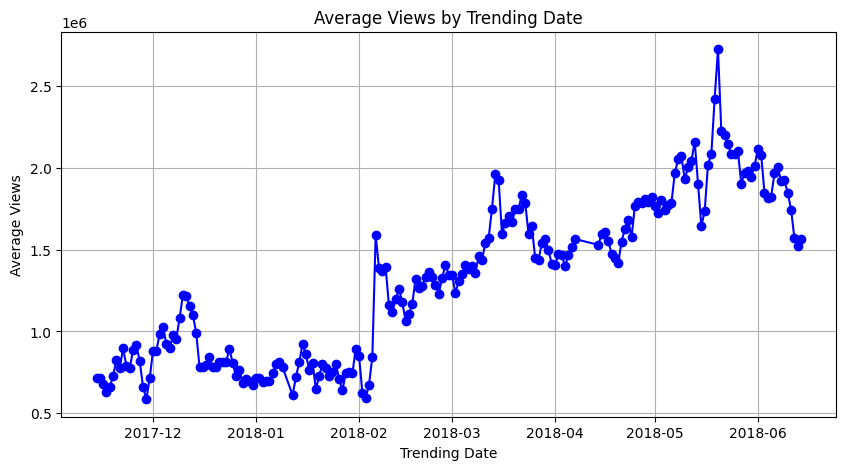

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Aggregate data
df_views = (df.groupBy("trending_date")
              .agg(F.avg("views").alias("avg_views"))
              .orderBy("trending_date"))

# Convert to Pandas for plotting
pdf = df_views.toPandas()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(pdf['trending_date'], pdf['avg_views'], color='blue', marker='o')
plt.title("Average Views by Trending Date")
plt.xlabel("Trending Date")
plt.ylabel("Average Views")
plt.grid(True)
plt.show()


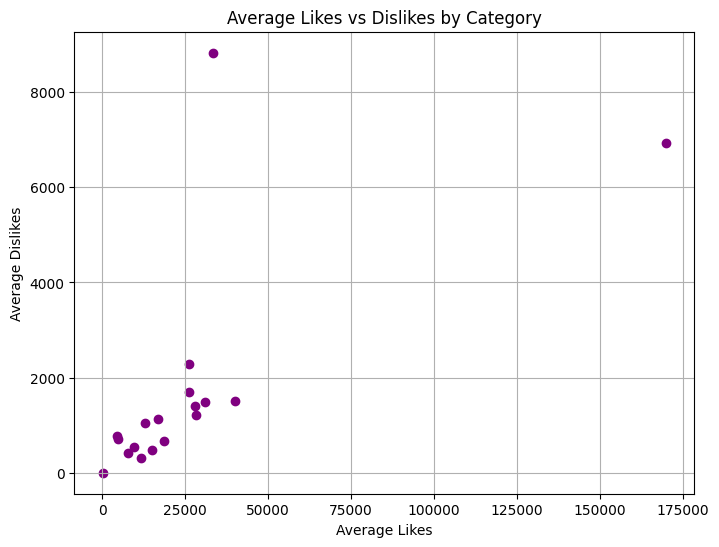

In [ ]:
df_engagement = (df.groupBy("category_id")
                   .agg(F.avg("likes").alias("avg_likes"),
                        F.avg("dislikes").alias("avg_dislikes"))
                   .orderBy("category_id"))

pdf = df_engagement.toPandas()

plt.figure(figsize=(8, 6))
plt.scatter(pdf['avg_likes'], pdf['avg_dislikes'], c='purple')
plt.title("Average Likes vs Dislikes by Category")
plt.xlabel("Average Likes")
plt.ylabel("Average Dislikes")
plt.grid(True)
plt.show()


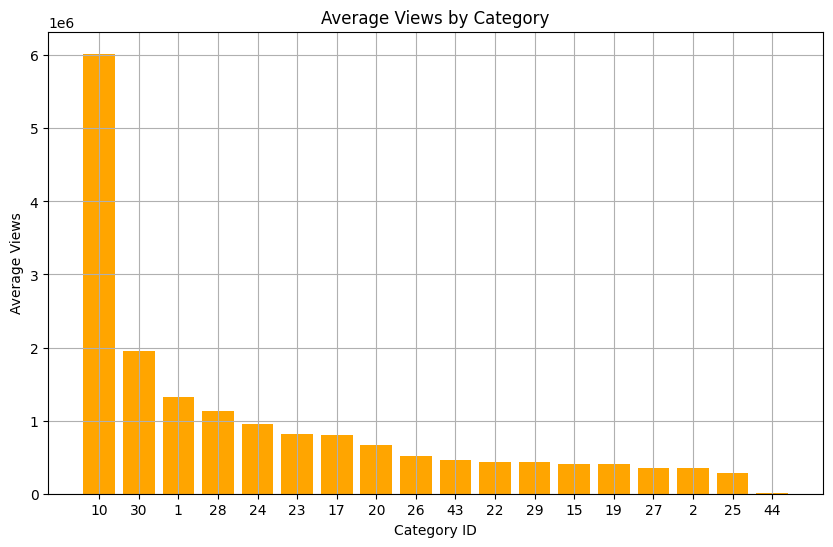

In [ ]:
df_category = (df.groupBy("category_id")
                 .agg(F.avg("views").alias("avg_views"))
                 .orderBy("avg_views", ascending=False))

pdf = df_category.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(pdf['category_id'].astype(str), pdf['avg_views'], color='orange')
plt.title("Average Views by Category")
plt.xlabel("Category ID")
plt.ylabel("Average Views")
plt.grid(True)
plt.show()


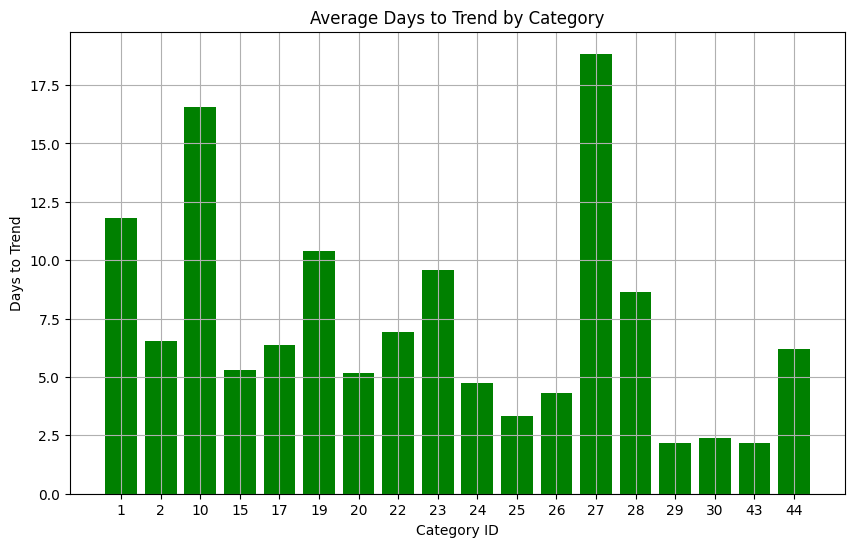

In [ ]:
from pyspark.sql.functions import datediff, to_date

df_time = (df.withColumn("days_to_trend",
                         datediff(F.col("trending_date"), F.to_date("publish_time")))
              .groupBy("category_id")
              .agg(F.avg("days_to_trend").alias("avg_days_to_trend"))
              .orderBy("category_id"))

pdf = df_time.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(pdf['category_id'].astype(str), pdf['avg_days_to_trend'], color='green')
plt.title("Average Days to Trend by Category")
plt.xlabel("Category ID")
plt.ylabel("Days to Trend")
plt.grid(True)
plt.show()


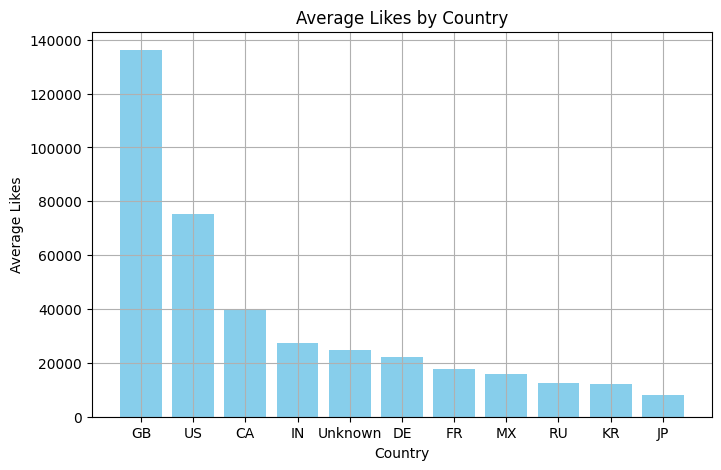

In [ ]:
df_country = (df.groupBy("Country")
                .agg(F.avg("likes").alias("avg_likes"))
                .orderBy("avg_likes", ascending=False))

pdf = df_country.toPandas()

plt.figure(figsize=(8, 5))
plt.bar(pdf['Country'], pdf['avg_likes'], color='skyblue')
plt.title("Average Likes by Country")
plt.xlabel("Country")
plt.ylabel("Average Likes")
plt.grid(True)
plt.show()
